In [1]:
import numpy as np 
import pandas as pd 
import cv2


import matplotlib.pyplot as plt

from nd2reader import ND2Reader

from tqdm import tqdm
from glob import glob
import os
import pickle

from MTT.track_manager import TrackManager

import tensorflow as tf

from tools.unet import Unet,Unet_ResNet,Unet_plusplus
from tools.losses import focal_loss

from sklearn.cluster import DBSCAN

from skimage import morphology
from skimage.filters import rank
from skimage.util import img_as_uint,img_as_ubyte

from scipy.optimize import curve_fit

import seaborn as sns

import h5py

c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [9]:
model = Unet_plusplus(1,512,loss='focal')

custom_objects = {"loss": focal_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('./arttu_model5')

In [10]:
path = os.path.join('F:/instru_projects/timelapses', '230912')

vid_name = max( glob(os.path.join(path,'*.nd2')), key =  lambda x: os.stat(x).st_size)

with ND2Reader(vid_name) as images:
    metas = images.metadata

#with ND2Reader()

In [12]:
drive = ['F:/instru_projects/timelapses/']
paths = ['230912']

#drive_e = ['']
vis = True
save = True
ball = morphology.disk(15)
conv_coef = 70

DBScan_distance = 5
DBScan_minSample = 2

num_bf = [metas["channels"].index(i) for i in ["BF"]][0]

if vis:
    cv2.namedWindow('vis', cv2.WINDOW_AUTOSIZE)

for path_,drive_ in zip(paths,drive):
    
    path = f'{drive_}{path_}'
    print(path)
    vid_name = max( glob(os.path.join(path,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)
    with ND2Reader(vid_name) as images:
        n_fields = images.metadata['fields_of_view'].stop
        m = images.metadata['pixel_microns']
        n_frames = images.metadata['num_frames']
        z_level = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))
        n_levels = images.metadata['z_levels'].stop
        z_step = z_level/n_levels
        channels = images.metadata['channels']
        n_channels = len(channels)
        vis_level = int(n_levels/2)
        metas = images.metadata

    counts = {}

    for i in channels:
        if i == "BF":
            continue
        else:
            counts[i] = {}
            counts[i]['dets'] = np.zeros((n_fields,n_frames))
            counts[i]['coords'] = {}
            for j in range(n_fields):
                counts[i]['coords'][j] = []

    skip = False
    t_id = 0
    v_id = 0

    with ND2Reader(vid_name) as images:

        images.iter_axes = 'tc'
        #images.iter_axes = 'vtc'
        images.bundle_axes = 'zyx'

        for idx,img in tqdm(enumerate(images),total=n_frames):
            
            c_id = idx%n_channels
            id_name = channels[c_id]
            # skip brightfield
            if (id_name == "BF"):
                print("Skipping BF")
                if idx != 0:
                    t_id += 1
               
                continue


            z_predictions = []
            normalized = np.zeros((n_levels,512,512))

            for i in images.metadata['z_levels']:

                final = cv2.normalize(img[i,...],  None, 0, 255, cv2.NORM_MINMAX)
                final = 255-cv2.resize(final,(512,512))
                normalized[i] = final

            if n_levels>11:
                res_1 = model.predict(np.tile(normalized[:7,...,np.newaxis],(1,1,1,3))/255.)
                res_2 = model.predict(np.tile(normalized[7:,...,np.newaxis],(1,1,1,3))/255.)
                res = np.vstack([res_1,res_2])
            else:
                res = model.predict(np.tile(normalized[...,np.newaxis],(1,1,1,3))/255.)

            convs = np.zeros_like(res[...,0],dtype=np.uint8)
            convs_ = np.zeros_like(res[...,0],dtype=np.uint8)

            for i in range(res.shape[0]):
                conv_ = rank.enhance_contrast_percentile(img_as_ubyte(res[i][...,0]),ball)
                convs_[i] = conv_
                conv = conv_ > conv_coef
                convs[i] = conv

            if vis:
                out = np.copy(np.tile(normalized[vis_level][...,None],(1,1,3))).astype(np.uint8)
                pred_vis = np.zeros((*out.shape[:2],3),dtype=np.uint8)
                conv = rank.enhance_contrast_percentile(img_as_ubyte(np.copy(res[vis_level][...,0])),ball)
                conv = conv>conv_coef
                pred_vis[...,1] = conv*255
                out = cv2.addWeighted(out,1.0,pred_vis,0.5,0)
                out = cv2.putText(out, f'{id_name}', (5,20), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (255,0,0), 2, cv2.LINE_AA)
                cv2.imshow('vis',out)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                

            z,x,y = np.where(convs)
            X = np.vstack([x,y,z]).T
            dets = 0
            coords = []
            if X.shape[0] != 0:

                clustering = DBSCAN(eps=DBScan_distance, min_samples=DBScan_minSample).fit(X)
                n_unique = np.unique(clustering.labels_)
                n_unique = n_unique[n_unique!=-1]
                dets = len(n_unique)-1
                
                for i in n_unique:
                    cond = clustering.labels_==i
                    weights = convs_[z[cond],x[cond],y[cond]]
                    y_c = np.average(x[cond],weights=weights)
                    x_c = np.average(y[cond],weights=weights)
                    y_c_i = int(np.round(y_c))
                    x_c_i = int(np.round(x_c))
                    z_c = np.average(z[cond],weights=weights)
                    coords.append([x_c,y_c,z_c])
                    if vis:
                    
                        out = cv2.circle(out, (x_c_i,y_c_i), radius=5, color=(0, 0, 255), thickness=-10)


                if vis:
                    cv2.imshow('vis',out)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break

            #id_name = channels[c_id]
            if (t_id != 0) and ((t_id%n_frames)==0):
                if not skip:
                    skip = True
                    v_id += 1
            else:
                skip = False
            print(v_id,t_id%n_frames,id_name,end='\r')
            counts[id_name]['dets'][v_id,t_id%n_frames] = dets
            counts[id_name]['coords'][v_id].append(coords)
            

    pp = path_.replace('/','_')
    if save:
        with open(f'./results/{pp}.pickle', 'wb') as handle:
            pickle.dump(counts, handle, protocol=pickle.HIGHEST_PROTOCOL)
if vis:
    cv2.destroyAllWindows()

F:/instru_projects/timelapses/230912


  0%|          | 0/57 [00:00<?, ?it/s]

1/1 [==============================] - 23s 23s/step


  2%|▏         | 1/57 [00:38<36:19, 38.91s/it]

  4%|▎         | 2/57 [00:39<15:04, 16.44s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


  5%|▌         | 3/57 [01:21<25:06, 27.89s/it]

  7%|▋         | 4/57 [01:21<15:05, 17.09s/it]

Skipping BF
1/1 [==============================] - 21s 21s/step


  9%|▉         | 5/57 [01:57<20:44, 23.94s/it]

 11%|█         | 6/57 [01:58<13:36, 16.01s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


 12%|█▏        | 7/57 [02:37<19:33, 23.48s/it]

 14%|█▍        | 8/57 [02:37<13:12, 16.17s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 16%|█▌        | 9/57 [03:17<18:52, 23.60s/it]

 18%|█▊        | 10/57 [03:18<12:55, 16.51s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


 19%|█▉        | 11/57 [03:59<18:32, 24.18s/it]

 21%|██        | 12/57 [04:00<12:45, 17.02s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


 23%|██▎       | 13/57 [04:40<17:40, 24.09s/it]

 25%|██▍       | 14/57 [04:41<12:11, 17.00s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


 26%|██▋       | 15/57 [05:22<16:56, 24.19s/it]

 28%|██▊       | 16/57 [05:23<11:47, 17.25s/it]

Skipping BF
1/1 [==============================] - 32s 32s/step


 30%|██▉       | 17/57 [06:16<18:34, 27.85s/it]

 32%|███▏      | 18/57 [06:16<12:49, 19.72s/it]

Skipping BF
1/1 [==============================] - 29s 29s/step


 33%|███▎      | 19/57 [07:05<17:54, 28.27s/it]

 35%|███▌      | 20/57 [07:05<12:20, 20.02s/it]

Skipping BF
1/1 [==============================] - 27s 27s/step


 37%|███▋      | 21/57 [07:53<17:03, 28.44s/it]

 39%|███▊      | 22/57 [07:54<11:44, 20.12s/it]

Skipping BF
1/1 [==============================] - 28s 28s/step


 40%|████      | 23/57 [08:41<15:54, 28.06s/it]

 42%|████▏     | 24/57 [08:41<10:54, 19.84s/it]

Skipping BF
1/1 [==============================] - 28s 28s/step


 44%|████▍     | 25/57 [09:28<14:50, 27.82s/it]

 46%|████▌     | 26/57 [09:28<10:10, 19.69s/it]

Skipping BF
1/1 [==============================] - 27s 27s/step


 47%|████▋     | 27/57 [10:16<14:05, 28.17s/it]

 49%|████▉     | 28/57 [10:17<09:37, 19.93s/it]

Skipping BF
1/1 [==============================] - 28s 28s/step


 51%|█████     | 29/57 [11:04<13:03, 27.97s/it]

 53%|█████▎    | 30/57 [11:05<08:53, 19.77s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 54%|█████▍    | 31/57 [11:47<11:32, 26.62s/it]

 56%|█████▌    | 32/57 [11:48<07:50, 18.84s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 58%|█████▊    | 33/57 [12:31<10:25, 26.06s/it]

 60%|█████▉    | 34/57 [12:31<07:04, 18.45s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


 61%|██████▏   | 35/57 [13:15<09:34, 26.14s/it]

 63%|██████▎   | 36/57 [13:16<06:28, 18.50s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


 65%|██████▍   | 37/57 [14:00<08:39, 25.99s/it]

 67%|██████▋   | 38/57 [14:00<05:49, 18.38s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 68%|██████▊   | 39/57 [14:43<07:42, 25.69s/it]

 70%|███████   | 40/57 [14:44<05:08, 18.17s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 72%|███████▏  | 41/57 [15:27<06:51, 25.74s/it]

 74%|███████▎  | 42/57 [15:28<04:33, 18.22s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 75%|███████▌  | 43/57 [16:10<05:54, 25.31s/it]

 77%|███████▋  | 44/57 [16:10<03:52, 17.92s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


 79%|███████▉  | 45/57 [16:52<04:59, 24.99s/it]

 81%|████████  | 46/57 [16:52<03:14, 17.68s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 82%|████████▏ | 47/57 [17:36<04:13, 25.34s/it]

 84%|████████▍ | 48/57 [17:36<02:41, 17.95s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


 86%|████████▌ | 49/57 [18:20<03:26, 25.76s/it]

 88%|████████▊ | 50/57 [18:21<02:07, 18.24s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


 89%|████████▉ | 51/57 [19:04<02:34, 25.71s/it]

 91%|█████████ | 52/57 [19:05<01:31, 18.21s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


 93%|█████████▎| 53/57 [19:48<01:43, 25.78s/it]

 95%|█████████▍| 54/57 [19:49<00:54, 18.23s/it]

Skipping BF
1/1 [==============================] - 23s 23s/step


 96%|█████████▋| 55/57 [20:28<00:48, 24.37s/it]

 98%|█████████▊| 56/57 [20:28<00:17, 17.22s/it]

Skipping BF
1/1 [==============================] - 23s 23s/step


100%|██████████| 57/57 [21:07<00:00, 23.70s/it]

58it [21:07, 16.77s/it]                        

Skipping BF
1/1 [==============================] - 22s 22s/step


59it [21:45, 22.93s/it]

60it [21:45, 16.21s/it]

Skipping BF
1/1 [==============================] - 21s 21s/step


61it [22:21, 21.99s/it]

62it [22:21, 15.56s/it]

Skipping BF
1/1 [==============================] - 22s 22s/step


63it [22:59, 22.19s/it]

64it [23:00, 15.71s/it]

Skipping BF
1/1 [==============================] - 22s 22s/step


65it [23:38, 22.37s/it]

66it [23:38, 15.83s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


67it [24:19, 23.28s/it]

68it [24:19, 16.50s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


69it [25:00, 23.69s/it]

70it [25:00, 16.76s/it]

Skipping BF
1/1 [==============================] - 27s 27s/step


71it [25:46, 25.33s/it]

72it [25:47, 17.96s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


73it [26:32, 26.06s/it]

74it [26:32, 18.47s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


75it [27:15, 25.84s/it]

76it [27:16, 18.27s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


77it [28:01, 26.20s/it]

78it [28:01, 18.53s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


79it [28:45, 26.16s/it]

80it [28:46, 18.51s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


81it [29:28, 25.57s/it]

82it [29:29, 18.10s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


83it [30:09, 24.83s/it]

84it [30:10, 17.57s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


85it [30:51, 24.66s/it]

86it [30:52, 17.45s/it]

Skipping BF
1/1 [==============================] - 26s 26s/step


87it [31:34, 24.99s/it]

88it [31:35, 17.69s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


89it [32:17, 25.10s/it]

90it [32:18, 17.79s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


91it [33:00, 25.00s/it]

92it [33:00, 17.69s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


93it [33:42, 24.86s/it]

94it [33:43, 17.58s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


95it [34:24, 24.76s/it]

96it [34:25, 17.53s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


97it [35:05, 24.48s/it]

98it [35:06, 17.32s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


99it [35:46, 24.17s/it]

100it [35:47, 17.12s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


101it [36:27, 24.08s/it]

102it [36:28, 17.05s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


103it [37:08, 23.97s/it]

104it [37:09, 16.96s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


105it [37:51, 24.64s/it]

106it [37:52, 17.45s/it]

Skipping BF
1/1 [==============================] - 25s 25s/step


107it [38:35, 25.04s/it]

108it [38:35, 17.74s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


109it [39:16, 24.66s/it]

110it [39:17, 17.45s/it]

Skipping BF
1/1 [==============================] - 24s 24s/step


111it [39:58, 24.70s/it]

112it [39:59, 17.57s/it]

Skipping BF
1/1 [==============================] - 12s 12s/step


112it [40:40, 21.79s/it]


KeyboardInterrupt: 

In [7]:
files_p = os.path.join(drive[0], paths[0])
files = glob(os.path.join("./results/", '230913.pickle'))

name = files_p

vid_path = glob(os.path.join(name, "*.nd2"))[0]

add_meta = False

def read_meta(vid_name):
    with ND2Reader(vid_name) as t_:
        return t_.metadata

processing = []
#processing = []
with h5py.File("./{}.hdf5".format(files[0][:-7]), "w") as f:
    for file_name in tqdm(files):
        print(file_name)
        with open(file_name,'rb') as handle:
            name = os.path.split(file_name)[-1].split('.')[0]
            tmp = pickle.load(handle)
            
            # group for each sample
            grp = f.create_group(name)
            for i in tmp.keys():
                # sub group for each channel
                sub_grp = grp.create_group(i)
                dets = tmp[i]['dets'].astype(int)
                coords = tmp[i]['coords']
                #stacked = []
                #print(f'{name}: t: {len(coords.keys())/4}')
                for loc in coords.keys():
                    coords_ = [c for c in coords[loc] if len(c) != 0]
                    times = [np.ones(len(c))*idx for idx,c in enumerate(coords_)]
                    comb = np.empty((0,4))
                    if len(coords_)!=0:
                        coord = np.concatenate(coords_)
                        comb = np.hstack([np.concatenate(times)[...,None],coord])

                    # add data to e.g 04-04-2022/GFP_U/1
                    sub_grp2 = sub_grp.create_group(f'{loc}')
                    set2 = sub_grp2.create_dataset("coords", comb.shape,data=comb, dtype='f')
                # add data to e.g 04-04-2022/GFP_U/
                set1 = sub_grp.create_dataset("dets", dets.shape,data=dets, dtype='i')

                if add_meta:
                    meta = read_meta(vid_path)
                    # add attributes to 04-04-2022
                    for ke in list(meta.keys()):
                        print(ke)
                        if name in meta[ke].keys():
                            m_info = meta[ke][name]
                            if isinstance(m_info,str):
                                grp.attrs[ke] = m_info
                            elif isinstance(m_info,list):
                                grp.attrs[ke] = np.array(m_info)
                            elif isinstance(m_info,dict):
                                for k in list(m_info.keys()):
                                    p_id = m_info[k]
                                    grp.attrs[f'P_{k}'] = np.array(p_id)


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

./results/230913.pickle


In [8]:
def tracking(path,out_path,skipping=[],processing=[],write_type='a',th=2):
    um_to_px = np.array([1/0.33,1/0.33,1/12.5,1.,1.])[None,...]
    px_xy = 6.5/(20)
    px_z = 5
    with h5py.File(out_path, write_type) as f2:
        with h5py.File(path, "r") as f:
            # iterate over different samples e.g 4.4.2022,...
            for k in tqdm(f.keys()):
                kk = str(k)
                if kk in skipping:
                    print(f'skipping: {kk}')
                    continue
                if (len(processing) != 0) and (kk not in processing):
                    print(f'skipping: {kk}')
                    continue
                print(f'processing: {kk}')
                grp = f2.require_group(f'{k}')
                for channel in tqdm(f[k].keys(),leave=False):
                    sub_grp = grp.require_group(f'{channel}')
                    for loc in tqdm(f[k][channel].keys(),leave=False):
                        if loc=='dets':
                            continue
                        sub_grp2 = sub_grp.require_group(f'{loc}')
                        coords = np.array(f[k][channel][loc]['coords'])
                        t_sorted = np.sort(np.unique(coords[:,0])).astype(int)
                        if len(t_sorted) == 0:
                            set2 = sub_grp2.require_dataset("coords", (0,5),data=np.empty((0,5)), dtype='f')
                            continue
                        tracker = TrackManager(min_count=3,max_count=5,gating=10)
                        t_max = t_sorted[-1]
                        idx = 0
                        for t in np.arange(t_max):
                            dets = np.empty((0,5))
                            if t in t_sorted:
                                mask = coords[:,0]==t
                                dets_ = coords[mask,1:]
                                dets = np.hstack([dets_,np.zeros((dets_.shape[0],2))])
                                dets = dets * um_to_px
                            print(len(dets))
                            tracker.update(dets,t,np.repeat(0,len(dets)))


                        data = tracker.trackers_all
                        coord_tmp = [np.stack(j.history) for j in data if len(j.history)>th]
                        samples = np.empty((0,5),dtype=float)
                        if len(coord_tmp) != 0:
                            coord = np.concatenate(coord_tmp)
                            timestamp = np.concatenate([j.indices for j in data if len(j.history)>th])
                            tmp = [len(j.indices) for j in data if len(j.history)>th]
                            track_ids = np.repeat(np.arange(len(tmp)),tmp)
                            samples = pd.DataFrame({'x':coord[:,0]*px_xy,'y':coord[:,1]*px_xy,'z':coord[:,2]*px_z,
                                         't':timestamp,'id':track_ids})
                    
        
                        set2 = sub_grp2.require_dataset("coords", samples.shape,data=samples, dtype='f')
                """
                name = f'{k}'
                for ke in list(meta.keys()):
                    if name in meta[ke].keys():
                        m_info = meta[ke][name]
                        if isinstance(m_info,str):
                            grp.attrs[ke] = m_info
                        elif isinstance(m_info,list):
                            grp.attrs[ke] = np.array(m_info)
                        elif isinstance(m_info,dict):
                            for k in list(m_info.keys()):
                                p_id = m_info[k]
                                grp.attrs[f'P_{k}'] = np.array(p_id)
                """

In [9]:
tracking('./results/230913.hdf5', './results/230913_final.hdf5', [],[],'w')

  0%|          | 0/1 [00:00<?, ?it/s]

processing: 230913


51
19
46
18
10
10
15
killed 16 tracks
6
killed 7 tracks
6
killed 24 tracks
12
killed 7 tracks
11
killed 1 tracks
7
killed 2 tracks
8
killed 5 tracks
11
16
17
killed 1 tracks
25
killed 3 tracks
31
39
killed 1 tracks
46
killed 2 tracks
59
killed 3 tracks
67
75
83
killed 1 tracks
85
killed 13 tracks
57
killed 8 tracks
93
97
98
96
killed 1 tracks
96
killed 12 tracks
61
killed 19 tracks
60
killed 1 tracks
59
59
killed 7 tracks
59
killed 3 tracks
60
killed 56 tracks
61
killed 2 tracks
104
57
105
102
59
102
killed 1 tracks
103
killed 17 tracks
104
killed 8 tracks
103
killed 24 tracks
109
killed 7 tracks
109
killed 24 tracks
104
killed 3 tracks
105
104
106
108
killed 1 tracks
110
killed 2 tracks


104
killed 2 tracks
89
64
46
34
19
14
12
killed 25 tracks
8
killed 19 tracks
5
killed 13 tracks
5
killed 15 tracks
8
killed 5 tracks
10
killed 4 tracks
13
killed 6 tracks
13
killed 3 tracks
23
killed 1 tracks
47
61
75
killed 1 tracks
93
92
killed 1 tracks
102
killed 3 tracks
108
killed 5 tracks
112
killed 7 tracks
114
killed 2 tracks
110
killed 24 tracks
126
killed 9 tracks
121
killed 3 tracks
117
killed 3 tracks
120
killed 1 tracks
123
122
killed 4 tracks
131
killed 47 tracks
131
killed 20 tracks
134
killed 7 tracks
133
killed 5 tracks
135
killed 12 tracks
136
killed 35 tracks
136
127
137
112
killed 1 tracks
133
killed 1 tracks
127
130
133
killed 28 tracks
130
killed 39 tracks
131
killed 27 tracks
114
killed 7 tracks
130
killed 11 tracks
130
133
killed 1 tracks
133
129
114
killed 6 tracks
118
killed 6 tracks
132


88
43
51
32
31
6
5
killed 32 tracks
10
killed 25 tracks
3
killed 17 tracks
3
killed 9 tracks
4
killed 21 tracks
6
killed 2 tracks
9
killed 1 tracks
12
killed 6 tracks
17
35
29
56
59
killed 1 tracks
55
killed 1 tracks
65
killed 2 tracks
69
killed 6 tracks
76
killed 9 tracks
92
killed 2 tracks
94
killed 15 tracks
78
killed 8 tracks
101
killed 4 tracks
104
killed 2 tracks
106
killed 3 tracks
102
killed 2 tracks
101
82
killed 24 tracks
81
killed 19 tracks
82
killed 6 tracks
83
killed 3 tracks
81
killed 2 tracks
84
killed 57 tracks
114
killed 6 tracks
107
116
115
104
107
killed 14 tracks
102
killed 27 tracks
106
killed 15 tracks
104
killed 8 tracks
116
killed 3 tracks
116
killed 3 tracks
107
killed 2 tracks
103
104
killed 1 tracks
107
killed 1 tracks
115
117
115
killed 6 tracks
102


116
123
86
60
44
72
53
killed 17 tracks
23
killed 52 tracks
32
killed 35 tracks
28
killed 22 tracks
19
killed 11 tracks
18
killed 24 tracks
19
killed 22 tracks
24
killed 18 tracks
34
killed 11 tracks
39
killed 7 tracks
51
killed 4 tracks
57
killed 6 tracks
61
killed 3 tracks
75
killed 7 tracks
78
killed 3 tracks
84
84
killed 2 tracks
80
killed 2 tracks
71
killed 5 tracks
72
killed 9 tracks
85
killed 2 tracks
91
killed 4 tracks
95
killed 1 tracks
98
killed 5 tracks
84
killed 3 tracks
86
killed 5 tracks
87
killed 14 tracks
87
killed 1 tracks
93
killed 1 tracks
93
killed 50 tracks
97
killed 2 tracks
93
killed 1 tracks
92
killed 1 tracks
93
93
97
103
killed 2 tracks
105
killed 33 tracks
99
killed 6 tracks
104
killed 6 tracks
93
killed 4 tracks
93
killed 16 tracks
100
killed 6 tracks
104
killed 5 tracks
104
killed 46 tracks
101
killed 6 tracks
96
killed 2 tracks
95


killed 2 tracks
96
killed 7 tracks
105
killed 2 tracks


6
7
5
7
8
8
6
8
8
5
6
8
6
6
6
9
7
killed 3 tracks
11
killed 1 tracks
8
7
7
7
killed 1 tracks
5
6
killed 3 tracks
6
killed 2 tracks
6
6
6
6
5
6
killed 1 tracks
4
killed 2 tracks
5
6
7
7
7
killed 1 tracks
8
9
killed 1 tracks
8
8
killed 2 tracks
7
9
7
7
killed 2 tracks
7
killed 1 tracks
9
killed 3 tracks
17
17
killed 5 tracks
8
7
7
7
killed 2 tracks
22


killed 3 tracks
20
killed 1 tracks
8
killed 1 tracks
3
4
3
3
3
3
3
3
killed 1 tracks
4
3
3
3
3
3
4
killed 1 tracks
7
8
killed 1 tracks
8
11
3
3
killed 1 tracks
3
3
3
3
killed 9 tracks
6
3
3
3
3
4
5
killed 1 tracks
5
7
5
7
5
killed 2 tracks
4
3
6
killed 3 tracks
3
killed 1 tracks
4
killed 2 tracks
3
3
4
4
killed 4 tracks
3
killed 1 tracks
4
killed 1 tracks
4
3
3
killed 1 tracks
3
killed 1 tracks
4
5
killed 1 tracks
5
killed 1 tracks
5


4
3
4
4
4
3
3
7
3
3
3
4
4
3
killed 3 tracks
5
4
3
6
5
5
5
killed 2 tracks
5
killed 1 tracks
4
4
killed 1 tracks
4
killed 3 tracks
5
3
5
4
4
4
killed 1 tracks
4
killed 2 tracks
4
5
killed 1 tracks
6
8
8
killed 1 tracks
3
4
3
3
killed 1 tracks
4
killed 1 tracks
5
killed 6 tracks
5
7
7


4
3
10
killed 1 tracks
10
9
14
3
7
6
killed 1 tracks
15


 60%|██████    | 3/5 [00:00<00:00,  4.70it/s]

4
4
5
6
6
4
4
killed 1 tracks
6
killed 2 tracks
5
killed 1 tracks
5
4
6
5
5
killed 5 tracks
7
8
8
8
killed 2 tracks
8
6
killed 3 tracks
6
4
killed 1 tracks
5
5
killed 1 tracks
9
killed 2 tracks
9
killed 2 tracks
7
killed 1 tracks
5
4
5
7
killed 1 tracks
6
killed 1 tracks
7
killed 4 tracks
6
8
7
killed 1 tracks
7
killed 1 tracks
12
7
killed 1 tracks
17
17
killed 2 tracks
7
8
12
killed 3 tracks
7
9
killed 2 tracks
14
killed 5 tracks
12
killed 1 tracks
11
15
killed 2 tracks
17
killed 4 tracks
18
33
37
42
26




100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


In [25]:
np.arange(0,10)[:2]

array([0, 1])

In [35]:
def MSD_tau(x,y,tau, dt):
    
    MSD = np.zeros(len(x))
    for idx in np.arange(len(x)):
        if (idx+tau >= len(x)):
            break
        MSD[idx]= np.sqrt( ((x[idx]-x[idx+tau])/dt)**2 + ((y[idx]-y[idx+tau])/dt)**2)

    return MSD[:idx].mean(), idx

def ACF_tau(x,y,tau):
    dt = 1
    dx = np.zeros(len(x)-1)
    dy = np.zeros(len(y)-1)
    ACF = np.zeros(len(x))

    for idx in np.arange(len(x)-1):
        dx[idx]= x[idx+dt]-x[idx]
        dy[idx]= y[idx+dt]-y[idx]
    
    for idx in np.arange(len(x)):
        if idx+tau >= len(x)-1:
            break
        ACF[idx]= ((dx[idx]*dx[idx+tau])+(dy[idx]*dy[idx+tau]))

    return ACF[:idx].mean(), idx

def theta_tau(x,y,tau, dt):

    d_theta = np.zeros(len(x))
    idx_theta = 1
    velocity_tau = np.zeros((len(x)-1,2))
    velocity_2tau = np.zeros((len(x)-1,2))

    for idx in np.arange(len(x)):

        if idx+2*tau >= len(x):
            velocity_tau[idx,0] = (x[idx+tau]-x[idx])/(tau*dt)
            velocity_tau[idx,1] = (y[idx+tau]-y[idx])/(tau*dt)
            if idx+tau >= len(x)-1:
                break
        else:
            velocity_tau[idx,0] = (x[idx+tau]-x[idx])/(tau*dt)
            velocity_tau[idx,1] = (y[idx+tau]-y[idx])/(tau*dt)

            velocity_2tau[idx,0] = (x[idx+2*tau]-x[idx])/(2*(tau*dt))
            velocity_2tau[idx,1] = (y[idx+2*tau]-y[idx])/(2*(tau*dt))

            d_theta[idx] = np.arccos(np.sum(velocity_tau[idx,:]*velocity_2tau[idx,:])/(np.sqrt(velocity_tau[idx,0]**2 + velocity_tau[idx,1]**2 )*np.sqrt(velocity_2tau[idx,0]**2 + velocity_2tau[idx,1]**2 )))
            idx_theta = idx
    
    return d_theta[:idx_theta].mean(), velocity_tau, idx_theta, idx


def MSD_2D(MSD, tau):
    
    def fit_2D_MSD(x,S,P):
        return 2*S**2*P**2*(np.exp(-x/P) + x/P - 1)

    popt, pcov = curve_fit(fit_2D_MSD, tau, MSD, method = "dogbox",maxfev = 10000)

    tau_pred = np.arange(tau[0],tau[-1], 0.01)
    MSD_pred =  fit_2D_MSD(tau_pred, *popt)

    diffusion_coef = popt[0]**2*popt[1]/2

    return popt, pcov, tau_pred, MSD_pred, diffusion_coef

def gen_sim_data(sim_num, n_steps, dt):

    def simulateWalk(left, mid, rigth, step_n):

        dims = 3
        step_set = [left,mid,rigth]
        origin = np.zeros((0,dims))

        #Simulate steps in 2D
        step_shape = (step_n,dims)
        steps = np.random.choice(a=step_set, size=step_shape)
        path = np.concatenate([origin, steps]).cumsum(0) + np.random.normal(0,0.001,(step_n,dims))
        xdata, ydata, zdata = path[:,0], path[:,1], path[:,2] 

        return xdata, ydata, zdata

    for i in range(sim_num):
        xdata, ydata, zdata = simulateWalk(-0.7,0,0.7,n_steps)

        simu_dict = {"x": xdata, "y": ydata, "z": zdata ,"idx": np.arange(len(xdata)), "id": np.repeat("sim_{}".format(i), len(xdata))}
        df_simu = pd.DataFrame.from_dict(simu_dict)
        if i == 0:
            df = df_simu
        else:
            df = pd.concat((df, df_simu))
    
    return df




In [146]:
day = "230912"
channels = "Red"
dt = 15*60 #s

add_sim = True

sub_df = {}

with h5py.File("./results/{}_final.hdf5".format(day), "r") as f:
    for count_1, i in enumerate(f[day].keys()):

        for count_2, j in enumerate(f[day][i].keys()):
            coords = np.array(f[day][i][j]['coords'])
            df_sub = pd.DataFrame(coords, columns = ['x','y','z','idx','id'])
            
            if add_sim:
                df_sub = pd.concat((df_sub, gen_sim_data(5, int(max(df_sub["idx"].unique())), dt)))

            for count_3, m in enumerate(df_sub.groupby(["id"])):
                tag = m[0]
                m = m[1].reset_index()
                sum = np.sum(np.diff(m["x"].values) + np.diff(m["y"].values))
                if sum == 0.0:
                    continue
                m["x_norm"] = m["x"] - m["x"].values[0]
                m["y_norm"] = m["y"] - m["y"].values[0]
                m["z_norm"] = m["z"] - m["z"].values[0]
                m["location"] = j
                m["channel"] = i
                m["dt"] = dt
                m["id"] = "track_{}".format(tag[0])
                m["time"] = m["idx"].values*m["dt"].values
                m["velocity_2D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 )
                m["velocity_3D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 + (np.gradient(m["z"].values)/dt)**2 )
                m["MSD"], idx = MSD_tau(m["x"].values,m["y"].values, 1, dt)
                l = m.shape[0]
                m["ACF_tau"] = np.zeros(l)
                m["theta_tau"] = np.zeros(l)
                m["MSD_tau"] = np.zeros(l)
                
                for k in range(1, l):
                    m.loc[k,"ACF_tau"], idx_tau = ACF_tau(m["x"].values, m["y"].values,k)
                    m.loc[k,"theta_tau"], velocity, idx_theta, idx_vel = theta_tau(m["x"].values, m["y"].values , k, dt)
                    if idx_vel > 1:
                        m.loc[k,"velocity_tau"] = np.sqrt((np.gradient(velocity[0,:idx_vel]))**2 + (np.gradient(velocity[0,:idx_vel]))**2 ).mean()
                    m.loc[k,"MSD_tau"], idx = MSD_tau(m["x"].values, m["y"].values, k, dt)
            
                if count_3 == 0:
                    df_ids = m
                else:
                    df_ids = pd.concat((df_ids, m))

            if count_2 == 0:
                df_locs = df_ids
            else:
                df_locs = pd.concat((df_locs, df_ids))
    
        if count_1 == 0:
            df = df_locs
        else:
            df = pd.concat((df, df_locs))
    
df_ids = None
df_locs = None
df_sub = None

df.to_csv(os.path.join("./results","{}_parsed_simu_{}.csv".format(day,add_sim)))

C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\198847519

C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:58: RuntimeWarning: overflow encountered in exp
  return 2*S**2*P**2*(np.exp(-x/P) + x/P - 1)


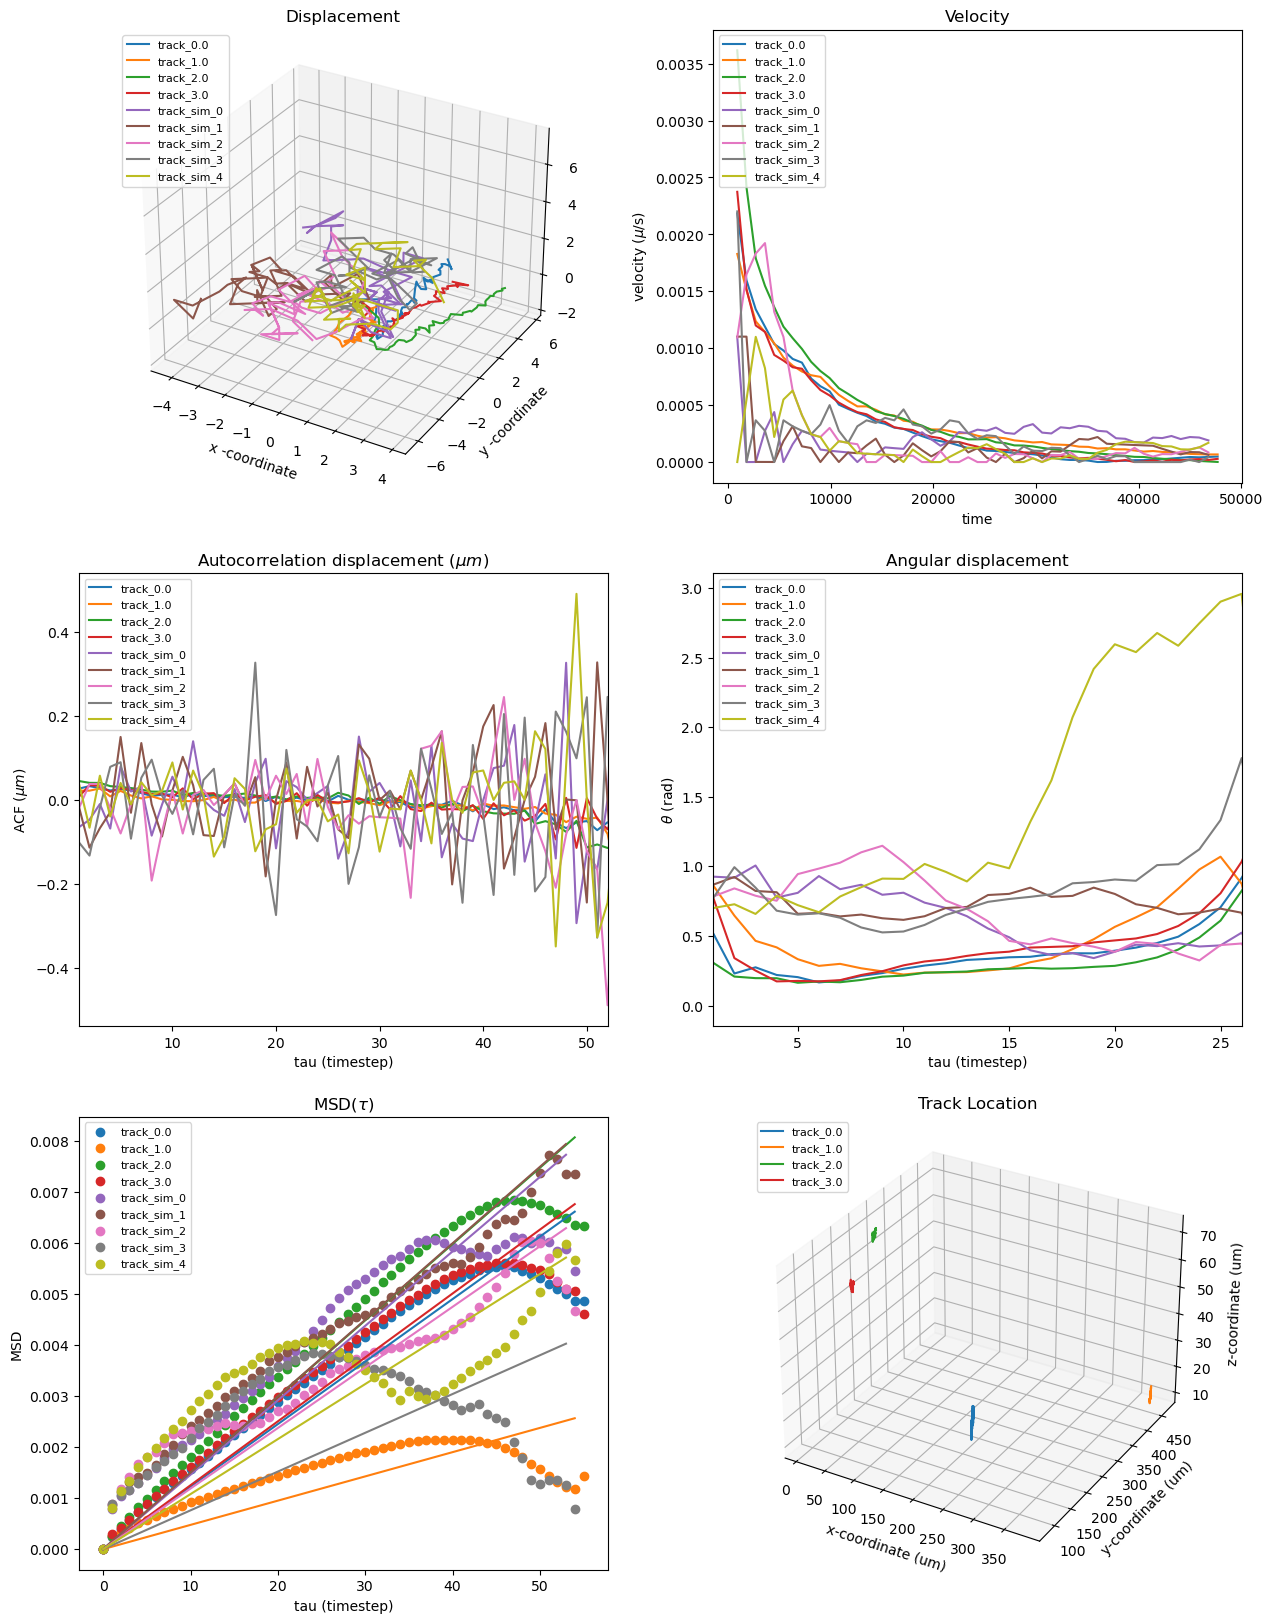

In [147]:
count = 0
for tags, k in df.groupby(["channel", "location"]):
    
    k = k.reset_index()#.loc[1:df.shape[0]-2,:].reset_index(
    last_time = k["idx"].values[-3]

    fig = plt.figure(figsize=(15,20))
    ax = [ 
        fig.add_subplot(321, projection='3d'),
        fig.add_subplot(322),
        fig.add_subplot(323),
        fig.add_subplot(324),
        fig.add_subplot(325),
        fig.add_subplot(326, projection='3d')
    ]

    ax[0].set_title(r"Displacement")
    for count, i in (k.groupby(["id"])):
        ax[0].plot(i["x_norm"],i["y_norm"],i["z_norm"], label =  count[0])

    ax[0].set_xlabel("x -coordinate")
    ax[0].set_ylabel("y -coordinate")
    ax[0].legend(loc = "upper left", fontsize = 8)

    sns.lineplot(x = "time", y = "velocity_tau", data = k, hue = "id", ax = ax[1])
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel(r"velocity ($\mu$/s)")
    ax[1].legend(loc = "upper left", fontsize = 8)

    sns.lineplot(x = "idx", y = "ACF_tau", data = k, hue = "id", ax = ax[2])
    ax[2].set_title(r"Autocorrelation displacement ($\mu m$)")
    ax[2].set_xlabel("tau (timestep)")
    ax[2].set_ylabel(r"ACF ($\mu m$)")
    ax[2].set_xlim([1,last_time])
    ax[2].legend(loc = "upper left", fontsize = 8)

    sns.lineplot(x = "idx", y = "theta_tau", data = k, hue = "id", ax = ax[3])
    ax[3].set_title("Angular displacement")
    ax[3].set_xlabel("tau (timestep)")
    ax[3].set_ylabel(r"$\theta$ (rad)")
    ax[3].set_xlim([1,int(last_time/2)])
    ax[3].legend(loc = "upper left", fontsize = 8)

    for count, i in (k.groupby(["id"])):
        ax[4].scatter(i["idx"], i["MSD_tau"], label = "{}".format(count[0]))
        popt, pcov, tau_pred, MSD_pred, diffusion_coef = MSD_2D(i["MSD_tau"].values[:-1], i["idx"].values[:-1])
        ax[4].plot(tau_pred, MSD_pred)

    #ax[2,0].legend()
    ax[4].set_title(r"MSD($\tau$)")
    ax[4].set_xlabel("tau (timestep)")
    ax[4].set_ylabel("MSD")
    ax[4].legend(loc = "upper left", fontsize = 8)
    #print("2D MSD" *popt, " Diff: ",  diffusion_coef)

    ax[5].set_title(r"Track Location")
    for count, i in (k.groupby(["id"])):
        if count[0].split("_")[1] != "sim":
            ax[5].plot(i["x"],i["y"],i["z"]*10, label =  "{}".format(count[0]))

    ax[5].set_xlabel("x-coordinate (um)")
    ax[5].set_ylabel("y-coordinate (um)")
    ax[5].set_zlabel("z-coordinate (um)")
    ax[5].legend(loc = "upper left", fontsize = 8)

    fig.savefig(os.path.join("./results", "timelapse_{}_{}_{}.png".format(day, tags[0], tags[1])))

    

In [ ]:
def SVD(x,y,dt):
    dx = np.zeros(len(x)-1)
    dy = np.zeros(len(y)-1)
    velocity = np.zeros((len(x)-1,2))

    for idx in np.arange(len(x)-1):
        velocity[idx,0] = (x[idx+dt]-x[idx])/dt
        velocity[idx,1] = (y[idx+dt]-y[idx])/dt

    U, S, Vh = np.linalg.svd(velocity, full_matrices=True)

    return velocity, U, S, Vh

In [121]:
i = "1"
j = "brightfield"
dt = 15*60
length = 100
num_sim = 10

df = gen_sim_data(num_sim, length, dt)

for count_3, m in enumerate(df.groupby(["id"])):
    
    m = m[1].reset_index()
    sum = np.sum(np.diff(m["x"].values) + np.diff(m["y"].values))
    if sum == 0.0:
        continue
    m["x_norm"] = m["x"] - m["x"].values[0]
    m["y_norm"] = m["y"] - m["y"].values[0]
    m["location"] = i
    m["channel"] = j
    m["dt"] = dt
    m["time"] = m["idx"].values*m["dt"].values
    m["velocity_2D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 )
    m["velocity_3D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 + (np.gradient(m["z"].values)/dt)**2 )
    m["MSD"], idx = MSD_tau(m["x"].values,m["y"].values, 1, dt)

    l = m.shape[0]
    m["ACF_tau"] = np.zeros(l)
    m["theta_tau"] = np.zeros(l)
    m["MSD_tau"] = np.zeros(l)
    m["velocity_tau"] = np.zeros(l)
    
    for k in range(1, l):
        m.loc[k,"ACF_tau"], idx_ACF = ACF_tau(m["x"].values, m["y"].values,k)
        m.loc[k,"theta_tau"], velocity, idx_theta, idx_vel = theta_tau(m["x"].values, m["y"].values , k, dt)
        if idx_vel > 1:
            m.loc[k,"velocity_tau"] = np.sqrt((np.gradient(velocity[0,:idx_vel]))**2 + (np.gradient(velocity[0,:idx_vel]))**2 ).mean()
        m.loc[k,"MSD_tau"], idx_tau = MSD_tau(m["x"].values, m["y"].values, k, dt)

    if count_3 == 0:
        df_ids = m
    else:
        df_ids = pd.concat((df_ids, m))

df = df_ids

C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:26: RuntimeWarning: Mean of empty slice.
  return ACF[:idx].mean(), idx
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\198847519

C:\Users\Arttu\AppData\Local\Temp\ipykernel_8340\1988475192.py:58: RuntimeWarning: overflow encountered in exp
  return 2*S**2*P**2*(np.exp(-x/P) + x/P - 1)


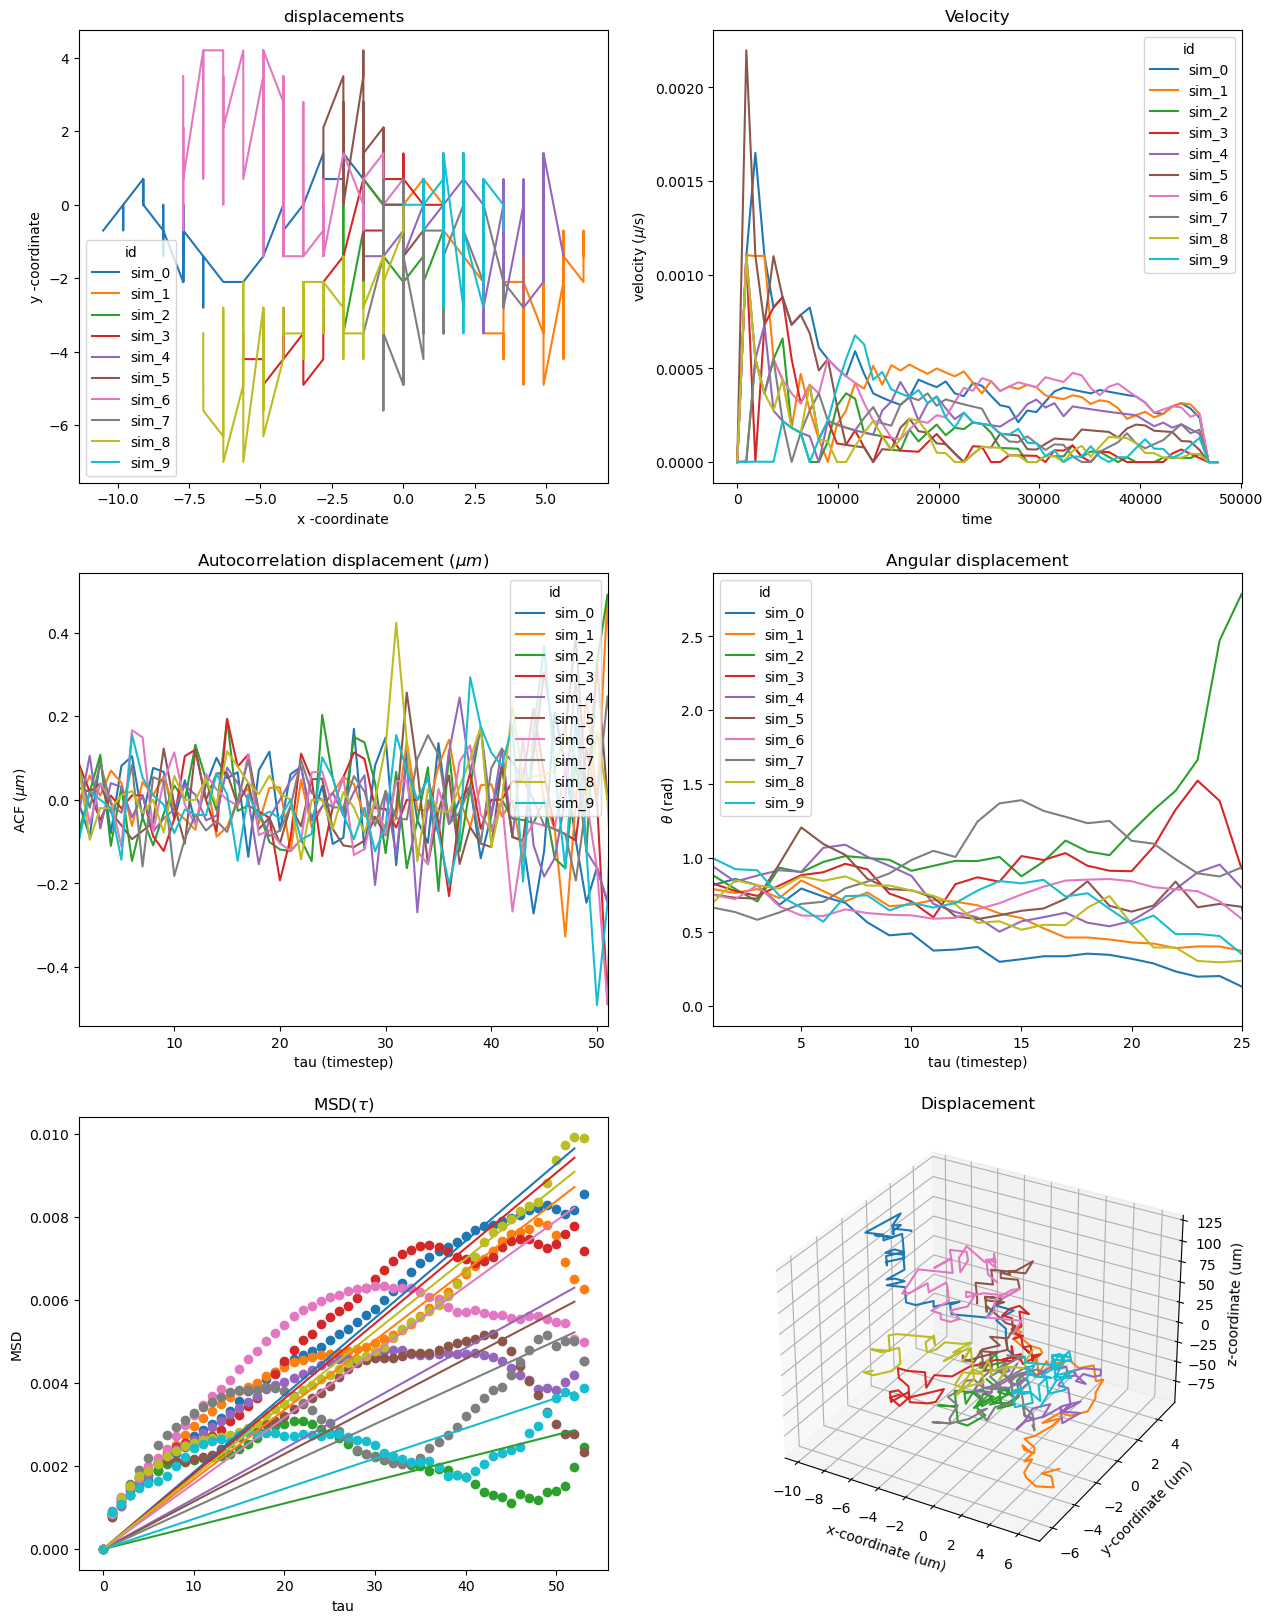

In [122]:
count = 0
for tags, k in df.groupby(["channel", "location"]):
    
    k = k.reset_index()#.loc[1:df.shape[0]-2,:].reset_index(
    last_time = k["idx"].values[-3]

    fig = plt.figure(figsize=(15,20))
    ax = [ 
        fig.add_subplot(321),
        fig.add_subplot(322),
        fig.add_subplot(323),
        fig.add_subplot(324),
        fig.add_subplot(325),
        fig.add_subplot(326, projection='3d')
    ]

    sns.lineplot(x = "x_norm", y = "y_norm", data = k, hue = "id", ax = ax[0])
    ax[0].set_title("displacements")
    ax[0].set_xlabel("x -coordinate")
    ax[0].set_ylabel("y -coordinate")

    sns.lineplot(x = "time", y = "velocity_tau", data = k, hue = "id", ax = ax[1])
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel(r"velocity ($\mu$/s)")

    sns.lineplot(x = "idx", y = "ACF_tau", data = k, hue = "id", ax = ax[2])
    ax[2].set_title(r"Autocorrelation displacement ($\mu m$)")
    ax[2].set_xlabel("tau (timestep)")
    ax[2].set_ylabel(r"ACF ($\mu m$)")
    ax[2].set_xlim([1,last_time])

    sns.lineplot(x = "idx", y = "theta_tau", data = k, hue = "id", ax = ax[3])
    ax[3].set_title("Angular displacement")
    ax[3].set_xlabel("tau (timestep)")
    ax[3].set_ylabel(r"$\theta$ (rad)")
    ax[3].set_xlim([1,int(last_time/2)])

    for count, i in (k.groupby(["id"])):
        ax[4].scatter(i["idx"], i["MSD_tau"], label = "track_{}".format(count))
        popt, pcov, tau_pred, MSD_pred, diffusion_coef = MSD_2D(i["MSD_tau"].values[:-1], i["idx"].values[:-1])
        ax[4].plot(tau_pred, MSD_pred, label = "Fit")

    #ax[2,0].legend()
    ax[4].set_title(r"MSD($\tau$)")
    ax[4].set_xlabel("tau")
    ax[4].set_ylabel("MSD")
    #print("2D MSD" *popt, " Diff: ",  diffusion_coef)

    ax[5].set_title(r"Displacement")
    for count, i in (k.groupby(["id"])):
        ax[5].plot(i["x"],i["y"],i["z"]*10, label =  "track_{}".format(count))

    ax[5].set_xlabel("x-coordinate (um)")
    ax[5].set_ylabel("y-coordinate (um)")
    ax[5].set_zlabel("z-coordinate (um)")

    fig.savefig(os.path.join("./results", "sim_{}_{}_{}.png".format(day, tags[0], tags[1])))